In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as TD
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Independent
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from collections import defaultdict
from tqdm.notebook import tqdm
from typing import List, Union
import gc
import os
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from IPython.display import Image, display
from IPython.core.display import HTML
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device='cuda'
USE_CUDA=True

##  MNIST

In [3]:
# train dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=True, download=True,
          transform=transforms.ToTensor()),
    batch_size=100, shuffle=True)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='.', train=False, transform=transforms.ToTensor()),
    batch_size=100, shuffle=True)

In [4]:
d = 32  # dimension of latent space 
nh =  100 # dinesnions of intermediate representations.
D = 28 * 28 # dimension of data space

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.func = nn.Sequential(
            nn.Linear(in_dim, 2*in_dim),
            nn.BatchNorm1d(2*in_dim),
            nn.ReLU(),
            nn.Linear(2*in_dim, out_dim),
            nn.BatchNorm1d(out_dim)
        )
        
        self.residual = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
    def forward(self, x):
        return self.func(x) + self.residual(x)
        
class Encoder(nn.Module):
    def __init__(self, dim: int, latent_dim: int, intermediate_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            ResBlock(dim, dim),
            ResBlock(dim, intermediate_dim),
            ResBlock(intermediate_dim, intermediate_dim),
            ResBlock(intermediate_dim, intermediate_dim),
            ResBlock(intermediate_dim, 2*latent_dim),
        )
    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, dim: int, latent_dim: int, intermediate_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            ResBlock(latent_dim, latent_dim),
            ResBlock(latent_dim, intermediate_dim),
            ResBlock(intermediate_dim, intermediate_dim),
            ResBlock(intermediate_dim, intermediate_dim),
            ResBlock(intermediate_dim, dim),
        )
    def forward(self, z):
        return self.model(z)

In [6]:
# encoder
# your code is here
enc = Encoder(D, d, nh)

In [7]:
# decoder
# your code is here
dec = Decoder(D, d, nh)


In [8]:
enc = enc.to(device)
dec = dec.to(device)

In [9]:
def loss_vae(x, encoder, decoder):
    """
    TODO
    returns
    1. the avergave value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """
    batch_size = x.size(0)
    encoder_output = encoder(x)
    pz = Independent(Normal(loc=torch.zeros(batch_size, d).to(device),
                            scale=torch.ones(batch_size, d).to(device)),
                     reinterpreted_batch_ndims=1)
    qz_x = Independent(Normal(loc=encoder_output[:, :d],
                              scale=torch.exp(encoder_output[:, d:])),
                       reinterpreted_batch_ndims=1)
    
    z = qz_x.rsample()
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output), 
                       reinterpreted_batch_ndims=1)
    
    loss = -(pz.log_prob(z) + px_z.log_prob((torch.flatten(x, start_dim = 1) > 0.5).float()) - qz_x.log_prob(z)).mean()
    
    return loss, decoder_output

In [10]:
from itertools import chain

def train_model(loss, model, batch_size, num_epochs, learning_rate):
    gd = torch.optim.Adam(
        chain(*[x.parameters() for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))]),
        lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

In [11]:
# choose appropiate hyper-parameters
# your code is here
BATCH_SIZE = 100
NUM_EPOCHS = 20
LR = 1e-4

In [12]:
train_model(loss_vae, model=[enc, dec], batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, learning_rate=LR)

Train loss: 211.81553649902344 Batch 600 of 600           
Test loss after an epoch: 202.7445068359375
Train loss: 163.6442413330078 Batch 600 of 600            
Test loss after an epoch: 169.00534057617188
Train loss: 154.79080200195312 Batch 600 of 600           
Test loss after an epoch: 152.9404296875
Train loss: 146.6720428466797 Batch 600 of 600            
Test loss after an epoch: 141.59381103515625
Train loss: 130.65316772460938 Batch 600 of 600           
Test loss after an epoch: 133.35272216796875
Train loss: 122.1391372680664 Batch 600 of 600            
Test loss after an epoch: 126.59048461914062
Train loss: 115.53385162353516 Batch 600 of 600           
Test loss after an epoch: 121.44775390625
Train loss: 112.38836669921875 Batch 600 of 600           
Test loss after an epoch: 116.74971008300781
Train loss: 114.45915985107422 Batch 600 of 600           
Test loss after an epoch: 112.9852066040039
Train loss: 107.30864715576172 Batch 600 of 600           
Test loss afte

In [13]:
def sample_vae(dec, n_samples=50):
    with torch.no_grad():
        pz = Independent(Normal(loc=torch.zeros(n_samples, d).to(device),
                            scale=torch.ones(n_samples, d).to(device)),
                     reinterpreted_batch_ndims=1)
        z = pz.rsample()
        decoder_output = dec(z)
        samples = torch.sigmoid(decoder_output)
        
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples
    
def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

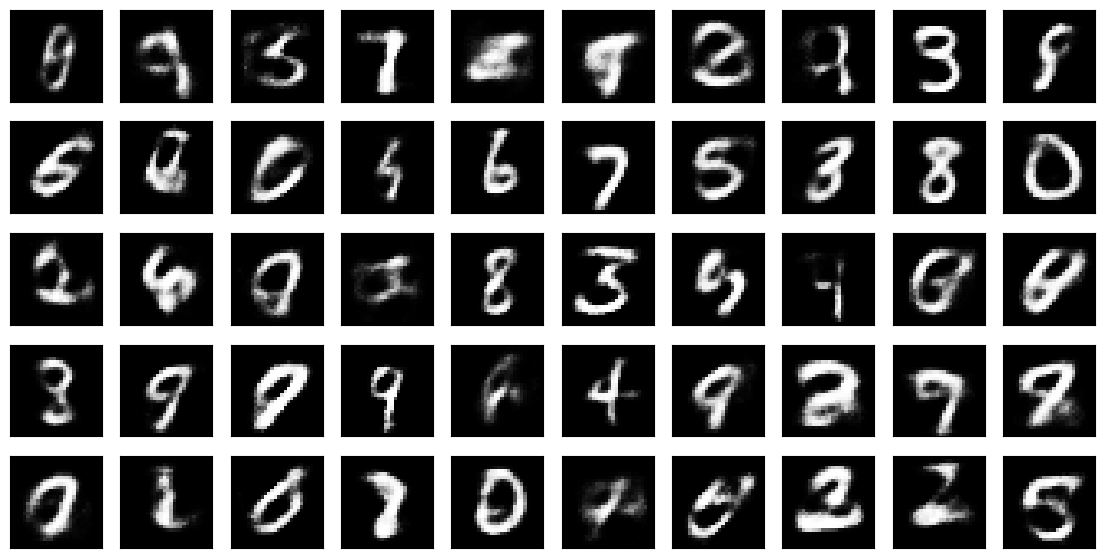

In [14]:
plot_samples(sample_vae(dec=dec))

In [15]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:25].float() / 255.)
        batch = batch.view(-1, D).to(device)
        _, rec = loss(batch, *model)
        rec = torch.sigmoid(rec)
        rec = rec.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()
    
        fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i in range(25):
            axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap='gray')
            axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap='gray')

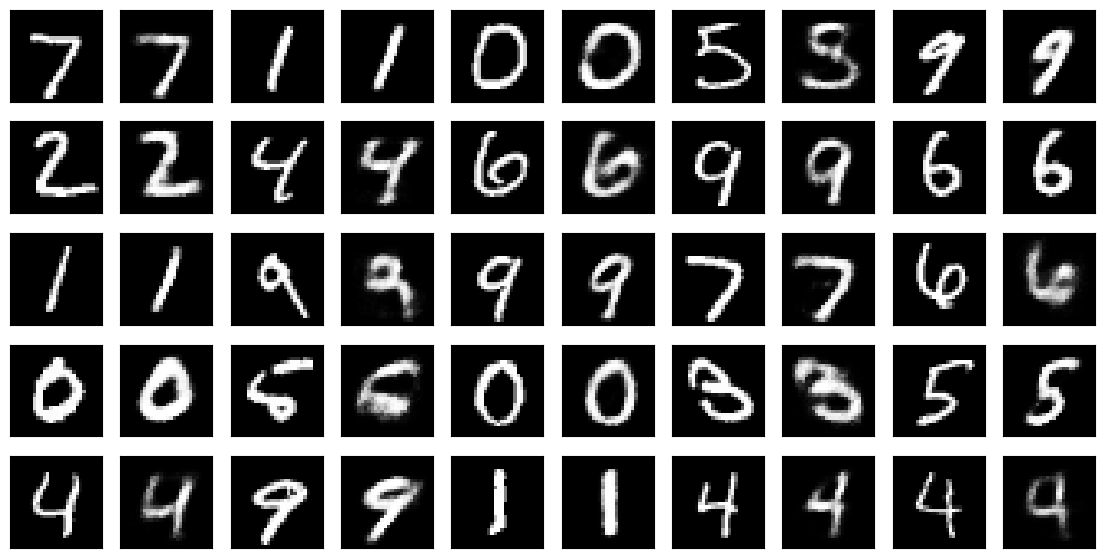

In [16]:
plot_reconstructions(loss_vae, [enc, dec])

In [17]:
def plot_interpolations(encoder, decoder):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:10].float() / 255.)
        batch = batch.view(-1, D).to(device)
        batch = encoder(batch)
        z_0 = batch[:5, :d].view(5, 1, d)
        z_1 = batch[5:, :d].view(5, 1, d)
        
        alpha = torch.linspace(0., 1., 10).to(device)
        alpha = alpha.view(1, 10, 1)
        
        interpolations_z = (z_0 * alpha + z_1 * (1 - alpha))
        interpolations_z = interpolations_z.view(50, d)
        interpolations_x = torch.sigmoid(decoder(interpolations_z))
        interpolations_x = interpolations_x.view(5, 10, 28, 28).cpu().numpy()
    
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(50):
        axes[i // 10, i % 10].imshow(interpolations_x[i // 10, i % 10], cmap='gray')

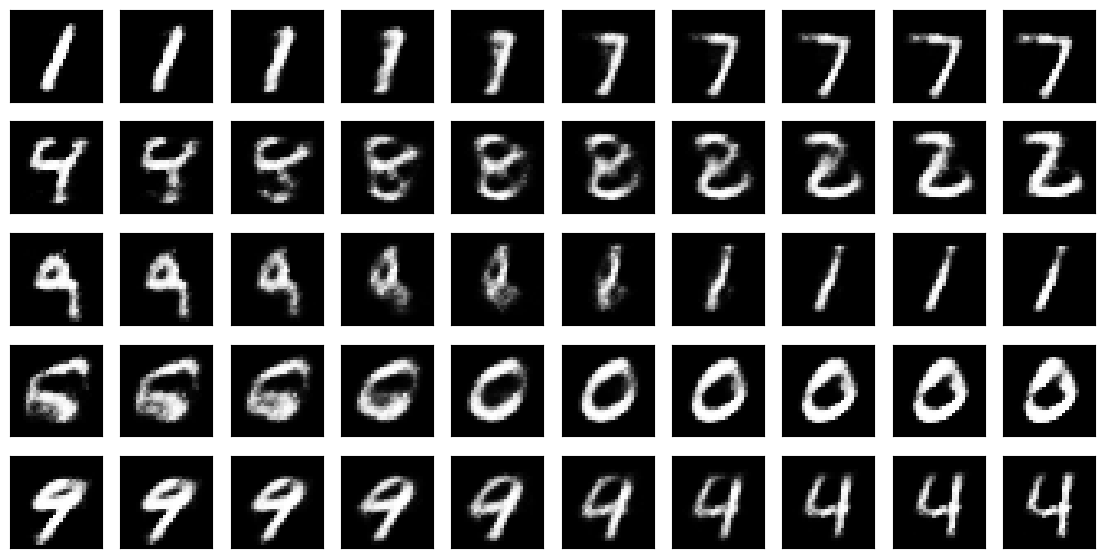

In [18]:
plot_interpolations(enc, dec)

In [19]:
def plot_tsne(objects, labels):
    from sklearn.manifold import TSNE
    embeddings = TSNE(n_components=2).fit_transform(objects)
    plt.figure(figsize=(8, 8))
    for k in range(10):
        embeddings_for_k = embeddings[labels == k]
        plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                    label='{}'.format(k))
    plt.legend()

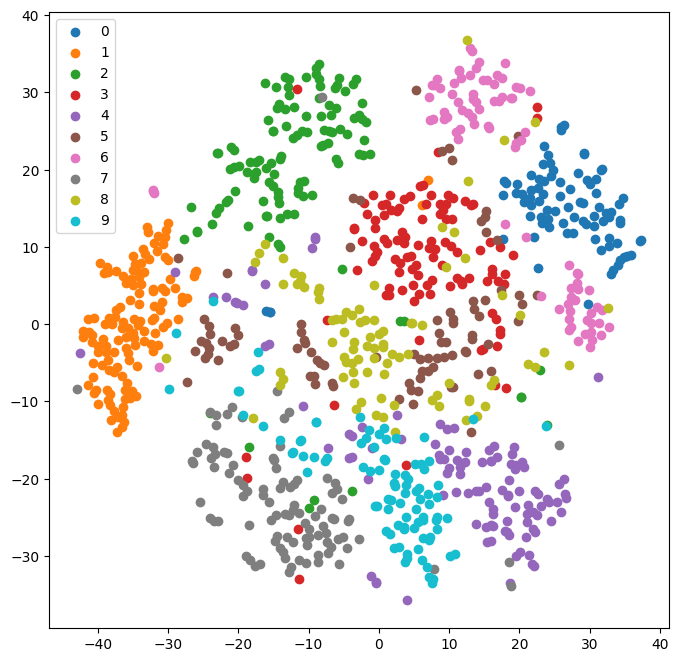

In [20]:
with torch.no_grad():
    batch = (test_loader.dataset.data[:1000].float() / 255.)
    batch = batch.view(-1, D).to(device)

    latent_variables = enc(batch)[:, :d]
    latent_variables = latent_variables.cpu().numpy()
    labels = test_loader.dataset.targets[:1000].numpy()

plot_tsne(latent_variables, labels)

##  CIFAR

In [4]:
TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

In [5]:
def plot_training_curves(train_losses, test_losses, logscale_y=False, logscale_x=False):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    if logscale_y:
        plt.semilogy()
    
    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel('Epoch', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Loss', fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()

In [6]:
def load_CIFAR10():
    train_data = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_data = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_data.data, test_data.data

    return train_data, test_data

In [7]:
def _load_dataset(name: str):
   
    if name == "cifar10":
        return load_CIFAR10()
    else:
        raise ValueError("The argument name must have the value  'cifar10'")
        

def load_dataset(
    name, flatten: bool = False, binarize: bool = True
):

    train_data, test_data = _load_dataset(name)

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    return train_data, test_data

In [8]:
def show_samples(
    samples,
    title,
    figsize=None,
    nrow=None,
) -> None:
    
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

In [9]:
def train_epoch(model, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    use_tqdm=False,
    use_cuda=False,
    loss_key='total_loss'
):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
        print(f"{test_losses['elbo_loss']=}")
        print(f"{test_losses['kl_loss']=}")
        print(f"{test_losses['recon_loss']=}")
    return dict(train_losses), dict(test_losses)

In [10]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)

    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)

    mean_1, mean_2 = mean_1.float(), mean_2.float()
    std_1, std_2  = std_1.float(), std_2.float()

    p  = Independent(torch.distributions.Normal(mean_1, std_1), 1)
    q  = Independent(torch.distributions.Normal(mean_2, std_2), 1)
    kl = torch.distributions.kl_divergence(p, q)

    return kl

In [11]:
def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    mean = mean.float()
    std  = torch.exp(log_std).float()

    prob = Independent(torch.distributions.Normal(mean, std), reinterpreted_batch_ndims = 3)
    nnl = -prob.log_prob(x)
    return nnl

Files already downloaded and verified
Files already downloaded and verified


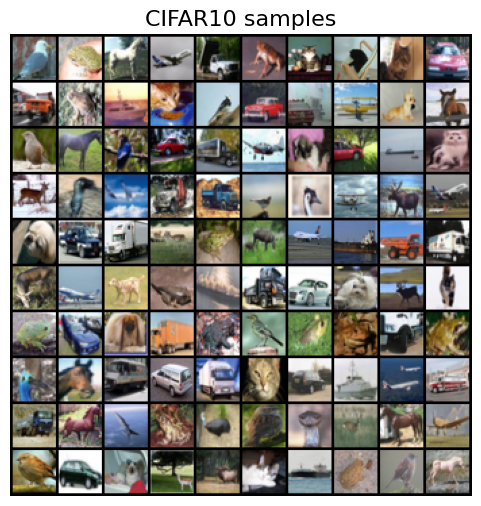

In [12]:
train_data, test_data = load_dataset('cifar10', flatten=False, binarize=False)
visualize_images(train_data, 'CIFAR10 samples')

In [13]:
class ResBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.func = nn.Sequential(
            nn.Conv2d(in_dim, 2*in_dim, kernel_size = 3, padding=1),
            nn.BatchNorm2d(2*in_dim),
            nn.ReLU(),
            nn.Conv2d(2*in_dim, out_dim, kernel_size = 3, padding=1),
            nn.BatchNorm2d(out_dim)
        )
        
        self.residual = nn.Conv2d(in_dim, out_dim, kernel_size = 3, padding=1) if in_dim != out_dim else nn.Identity()
    def forward(self, x):
        return self.func(x) + self.residual(x)

class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent, itermediate_dim = 32):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        # ====
        # your code
        # the possible variant of the architecture:
        # conv2d(32) -> relu -> conv(64) -> relu -> conv(128) -> relu -> conv(256) -> fc(2 * n_latent)
        # but we encourage you to create your own
        
        # ====
        
        self.model = nn.Sequential(
            ResBlock(3, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            nn.MaxPool2d(2),
            ResBlock(itermediate_dim, 2*itermediate_dim),
            ResBlock(2*itermediate_dim, 2*itermediate_dim),
            nn.MaxPool2d(2),
            ResBlock(2*itermediate_dim, 4*itermediate_dim),
            ResBlock(4*itermediate_dim, 4*itermediate_dim),
            nn.MaxPool2d(2),
            ResBlock(4*itermediate_dim, 8*itermediate_dim),
            ResBlock(8*itermediate_dim, 8*itermediate_dim),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(8*itermediate_dim, 2*n_latent)
        )

    def forward(self, x):
        # ====
        # your code
        # 1) apply convs
        # 2) reshape the output to 2d matrix for last fc layer
        # 3) apply fc layer
        
        # ====
        return self.model(x)

 

In [14]:
class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape, itermediate_dim = 32):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        # ====
        # your code
        # the possible variant of the architecture:
        # fc -> conv2dtranspose(128) -> relu -> conv2dtranspose(64) -> relu 
        # -> conv2dtranspose(32) -> relu -> conv2dtranspose(3)
        # but we encourage you to create your own architecture
        
        # ====
        self.model = nn.Sequential(
            nn.ConvTranspose2d(n_latent, n_latent, stride=2, kernel_size = 2),
            ResBlock(n_latent, itermediate_dim*8),
            ResBlock(itermediate_dim*8, itermediate_dim*8),
            ResBlock(itermediate_dim*8, itermediate_dim*8),
            nn.ConvTranspose2d(itermediate_dim*8, itermediate_dim*8, stride=2, kernel_size = 2),
            ResBlock(itermediate_dim*8, itermediate_dim*4),
            ResBlock(itermediate_dim*4, itermediate_dim*4),
            ResBlock(itermediate_dim*4, itermediate_dim*4),
            nn.ConvTranspose2d(itermediate_dim*4, itermediate_dim*4, stride=2, kernel_size = 2),
            ResBlock(itermediate_dim*4, itermediate_dim*2),
            ResBlock(itermediate_dim*2, itermediate_dim*2),
            ResBlock(itermediate_dim*2, itermediate_dim*2),
            nn.ConvTranspose2d(itermediate_dim*2, itermediate_dim*2, stride=2, kernel_size = 2),
            ResBlock(itermediate_dim*2, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            nn.ConvTranspose2d(itermediate_dim, itermediate_dim, stride=2, kernel_size = 2),
            ResBlock(itermediate_dim, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            ResBlock(itermediate_dim, 3),
        )
        

    def forward(self, z):
        # ====
        # your code
        # 1) apply fc layer
        # 2) reshape the output to 4d tensor 
        # 3) apply conv layers
        
        # ====
        b, c = z.size()
        z = z.view(b, c, 1, 1)
        res = self.model(z)
        return res

In [15]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent, beta=1):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta
      
        self.encoder = ConvEncoder(self.input_shape, self.n_latent)
        self.decoder = ConvDecoder(self.n_latent, self.input_shape)

    def prior(self, n, use_cuda=True):
     
        z = torch.randn(n, self.n_latent).cuda()
        if use_cuda:
            z = z.cuda()
        return z

    def forward(self, x):
        # ====
        # your code
        # 1) apply encoder to get mu_z, log_std_z
        # 2) apply reparametrization trick (use self.prior)
        # 3) apply decoder to get mu_x (which corresponds to reconstructed x)
        
        # ====
        mu_z, log_std_z = torch.tensor_split(self.encoder(x), 2, dim = 1)
        z = mu_z + torch.exp(log_std_z) * self.prior(x.shape[0])
        mu_x = self.decoder(z)
        return mu_z, log_std_z, mu_x
        
    def loss(self, x):
        # ====
        # your code
        # 1) make forward step to get mu_z, log_std_z, x_recon
        # 2) calculate recon_loss (use get_normal_nll)
        # 3) calcucalte kl_loss (use get_normal_KL)
        
        # ==== 
        mu_z, log_std_z, mu_x = self(x)
        recon_loss = torch.mean(get_normal_nll(x, mu_x, torch.zeros_like(mu_x)))
        kl_loss = torch.mean(get_normal_KL(mu_z, log_std_z, torch.zeros_like(mu_z), torch.zeros_like(log_std_z)))
        elbo_loss = self.beta * kl_loss + recon_loss
        dict_loss = {"recon_loss": recon_loss, "kl_loss":kl_loss, "elbo_loss":elbo_loss}
        return dict_loss

    def sample(self, n):
        with torch.no_grad():
            
            x_recon = self.decoder(self.prior(n))
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

In [17]:
# ====
# your code
# choose these parameters

BATCH_SIZE = 256 # any adequate value
EPOCHS = 10   # < 16
LR = 0.3*1e-3         # < 1e-3
N_LATENS = 512  # 128 < _ < 1024
BETA = 1       # 0.1 < _ < 10
# ====

# we center the data, because it helps the model to fit better
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = torch.utils.data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), N_LATENS, BETA)

train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    loss_key='elbo_loss', 
    use_tqdm=True, 
    use_cuda=True, 
)

 10%|██████████████▋                                                                                                                                    | 1/10 [00:25<03:53, 25.93s/it]

test_losses['elbo_loss']=[3094.332926171875]
test_losses['kl_loss']=[14.971383602905274]
test_losses['recon_loss']=[3079.36155703125]


 20%|█████████████████████████████▍                                                                                                                     | 2/10 [00:51<03:27, 25.89s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875]


 30%|████████████████████████████████████████████                                                                                                       | 3/10 [01:18<03:02, 26.06s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375, 3018.09604453125]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515, 17.896848526000976]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875, 3000.19918671875]


 40%|██████████████████████████████████████████████████████████▊                                                                                        | 4/10 [01:44<02:36, 26.14s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375, 3018.09604453125, 3013.622733203125]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515, 17.896848526000976, 15.7869962890625]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875, 3000.19918671875, 2997.835743359375]


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 5/10 [02:10<02:11, 26.21s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375, 3018.09604453125, 3013.622733203125, 3010.28936640625]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515, 17.896848526000976, 15.7869962890625, 16.94384201660156]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875, 3000.19918671875, 2997.835743359375, 2993.345513671875]


 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6/10 [02:37<01:45, 26.30s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375, 3018.09604453125, 3013.622733203125, 3010.28936640625, 2994.43947890625]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515, 17.896848526000976, 15.7869962890625, 16.94384201660156, 18.155687518310547]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875, 3000.19918671875, 2997.835743359375, 2993.345513671875, 2976.2837921875]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7/10 [03:03<01:18, 26.30s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375, 3018.09604453125, 3013.622733203125, 3010.28936640625, 2994.43947890625, 2993.496827734375]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515, 17.896848526000976, 15.7869962890625, 16.94384201660156, 18.155687518310547, 19.590309591674806]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875, 3000.19918671875, 2997.835743359375, 2993.345513671875, 2976.2837921875, 2973.906525]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8/10 [03:29<00:52, 26.32s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375, 3018.09604453125, 3013.622733203125, 3010.28936640625, 2994.43947890625, 2993.496827734375, 2984.989001171875]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515, 17.896848526000976, 15.7869962890625, 16.94384201660156, 18.155687518310547, 19.590309591674806, 19.92540301513672]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875, 3000.19918671875, 2997.835743359375, 2993.345513671875, 2976.2837921875, 2973.906525, 2965.0636109375]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9/10 [03:56<00:26, 26.38s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375, 3018.09604453125, 3013.622733203125, 3010.28936640625, 2994.43947890625, 2993.496827734375, 2984.989001171875, 2979.917111328125]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515, 17.896848526000976, 15.7869962890625, 16.94384201660156, 18.155687518310547, 19.590309591674806, 19.92540301513672, 20.37850163269043]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875, 3000.19918671875, 2997.835743359375, 2993.345513671875, 2976.2837921875, 2973.906525, 2965.0636109375, 2959.53861875]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:22<00:00, 26.29s/it]

test_losses['elbo_loss']=[3094.332926171875, 3041.875755859375, 3018.09604453125, 3013.622733203125, 3010.28936640625, 2994.43947890625, 2993.496827734375, 2984.989001171875, 2979.917111328125, 2978.494498046875]
test_losses['kl_loss']=[14.971383602905274, 14.657920709228515, 17.896848526000976, 15.7869962890625, 16.94384201660156, 18.155687518310547, 19.590309591674806, 19.92540301513672, 20.37850163269043, 19.881049017333986]
test_losses['recon_loss']=[3079.36155703125, 3027.21784921875, 3000.19918671875, 2997.835743359375, 2993.345513671875, 2976.2837921875, 2973.906525, 2965.0636109375, 2959.53861875, 2958.613444921875]


recon_loss: 2958.6134
kl_loss: 19.8810
elbo_loss: 2978.4945


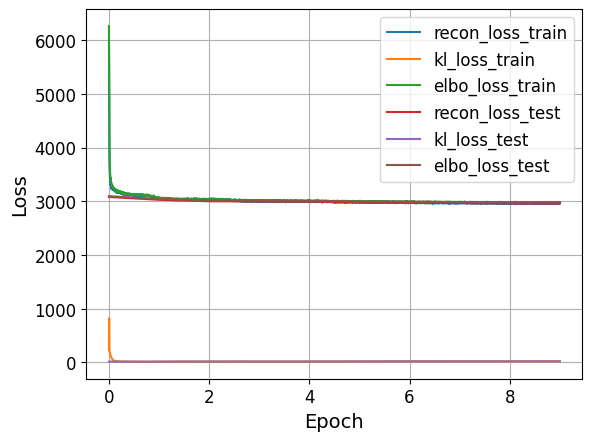

In [18]:
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

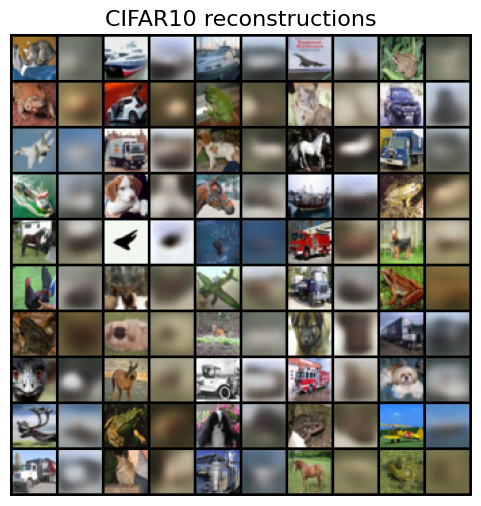

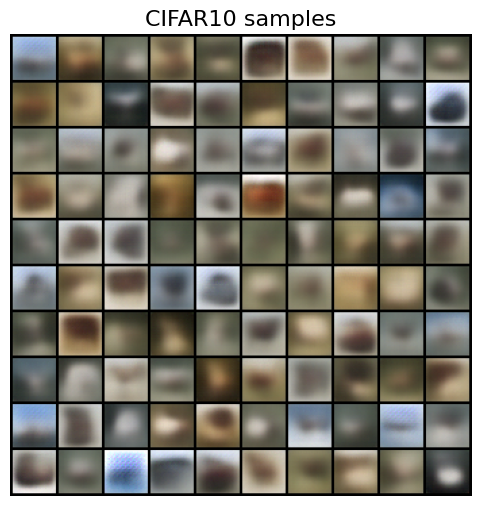

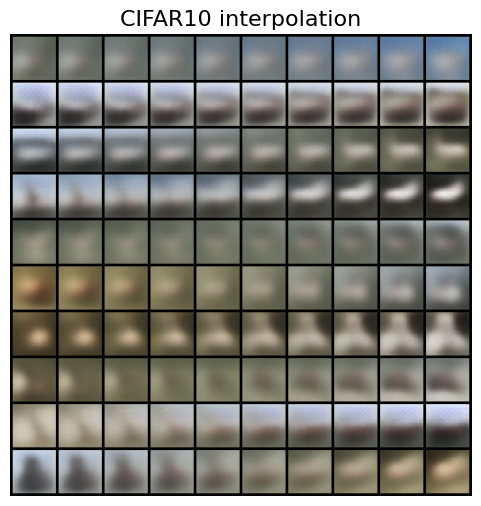

In [19]:
samples = model.sample(100)
USE_CUDA=True
x = next(iter(test_loader))[:50]

if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z[:, :N_LATENS]), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    z = model.encoder(x)
    z = z[:, :N_LATENS]
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')
show_samples(samples, 'CIFAR10 samples')
show_samples(interps, 'CIFAR10 interpolation')